<a href="https://colab.research.google.com/github/Pavionio/Fear_and_Hate_in_Taxi/blob/main/anomaly_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.4 MB/s eta 0:00:00


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import random
import geopy.distance as gp
import plotly.express as px
import math
import geopandas as gpd
from shapely.geometry import Point
import shapely
import json
from sklearn.ensemble import IsolationForest


In [3]:

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [11]:
!kaggle competitions list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [13]:
trip_duration = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/nyc_taxi_trip_duration.csv')
weather = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/nyc_2016_weather.csv')

In [14]:
trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848
...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447


In [60]:
def geo_anomalies(data : pd.DataFrame) -> None :
    
    
    df_for_pickup = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/taxi_zones.csv')  
    df_for_dropoff = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/taxi_zones.csv')  #update with the great help of Pavel Fadeev

    polygon_for_pickup = gpd.GeoDataFrame(geometry=shapely.wkt.loads(df_for_pickup.the_geom))
    polygon_for_dropoff = gpd.GeoDataFrame(geometry=shapely.wkt.loads(df_for_dropoff.the_geom))

    ls=[]

    for _,row in trip_duration.iterrows():
        ls.append(polygon_for_pickup.contains(Point(row['pickup_longitude'],row['pickup_latitude'])).any() and polygon_for_dropoff.contains(Point(row['dropoff_longitude'],row['dropoff_latitude'])).any())

    
    pickup_longitude = trip_duration[['id', 'pickup_longitude']].rename(columns={'pickup_longitude': 'longitude'})
    pickup_longitude['type'] = 'pickup'
    dropoff_longitude = trip_duration[['id', 'dropoff_longitude']].rename(columns={'dropoff_longitude': 'longitude'})
    dropoff_longitude['type'] = 'dropoff'

    longitudes = pd.concat((pickup_longitude, dropoff_longitude))

    pickup_latitude = trip_duration[['id', 'pickup_latitude']].rename(columns={'pickup_latitude': 'latitude'})
    pickup_latitude['type'] = 'pickup'
    dropoff_latitude = trip_duration[['id', 'dropoff_latitude']].rename(columns={'dropoff_latitude': 'latitude'})
    dropoff_latitude['type'] = 'dropoff'

    latitudes = pd.concat((pickup_latitude, dropoff_latitude))

    coords = pd.merge(longitudes, latitudes, on=['id', 'type'])
        

    with open('/content/gdrive/MyDrive/intensive/Project/NYC Taxi Zones.geojson') as f:
        taxi_zones = json.load(f)

    fig = px.scatter_mapbox(coords[:100000], lat='latitude', lon='longitude', hover_name='type')
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(mapbox_bounds={"west": -180, "east": -50, "south": 20, "north": 90})
    fig.update_traces(cluster=dict(enabled=True))
    fig.update_layout(
        mapbox = {
            'style': "open-street-map",
            'center': { 'lon': -73.9662, 'lat': 40.7834},
            'zoom': 9, 'layers': [{
                'source': taxi_zones,
                'type': "fill", 'below': "traces", 'color': "gray", 'name': 'Область работы такси',
            'opacity': 0.5}]},
        margin = {'l':0, 'r':0, 'b':0, 't':0})
    fig.show()



    data['geo_anomalies'] = list(map(lambda x: not x, ls))



In [86]:
def trip_count_anomalies(data : pd.DataFrame) -> None :

  
    data.sort_values(by=['pickup_datetime'])
    data['ds'] = pd.to_datetime(data['pickup_datetime'].str.slice(stop=10))
    duration = data.groupby('ds',as_index=False).id.count()
    duration.rename(columns={"id": "y"},inplace=True)

    model = IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.05), max_features=1.0)

    model.fit(duration[['y']])
    
    score_anomalies =  model.decision_function(duration[['y']])
    #print('Isolation_Forest score is ', np.mean([-1*s + 0.5 for s in score_anomalies])
    
    duration['day_anomaly']=model.predict(duration[['y']])

    an = duration.loc[duration['day_anomaly'] == -1]
    an.sort_values(by=['y'])


    plt.plot(duration.ds, duration['y'])
    plt.scatter(an.ds, an['y'], c='red', s=9)
    plt.show()

    return duration


In [ ]:
def trip_count_anomalies

In [74]:
def Catch_Anomalies(data : pd.DataFrame, search_geo_anomalies=True, search_count_anomalies=True):

    day_duration =None

    if 'pickup_longitude' in data.columns and search_geo_anomalies: #можно проверять по всем колонкам координат
      geo_anomalies(data)

    if 'pickup_datetime' in data.columns and search_count_anomalies:
      day_duration = trip_count_anomalies(data)

    

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



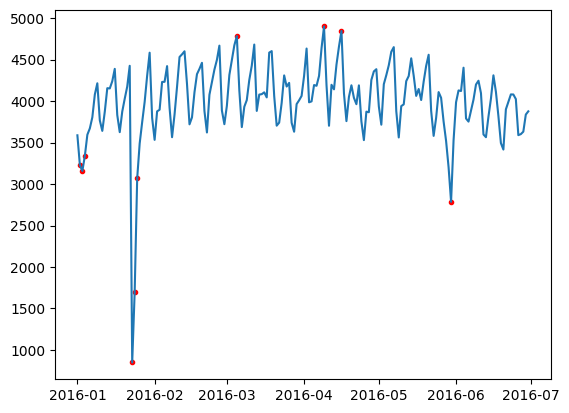

In [87]:
Catch_Anomalies(trip_duration,search_geo_anomalies=False)

In [90]:
def get_distance(p1, p2):
    # p1 и p2 - это кортежи из двух элементов - координаты точек
    radius = 6373.0

    lon1 = math.radians(p1[0])
    lat1 = math.radians(p1[1])
    lon2 = math.radians(p2[0])
    lat2 = math.radians(p2[1])

    d_lon = lon2 - lon1
    d_lat = lat2 - lat1

    a = math.sin(d_lat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2) ** 2
    c = 2 * math.atan2(a ** 0.5, (1 - a) ** 0.5)

    distance = radius * c
    return distance

In [91]:
trip_duration['distance'] = trip_duration.apply(lambda x: get_distance((x.pickup_longitude, x.pickup_latitude), (x.dropoff_longitude, x.dropoff_latitude)), axis=1)
trip_duration['avg_speed'] = trip_duration.distance /  trip_duration.trip_duration * 3600 # км / ч

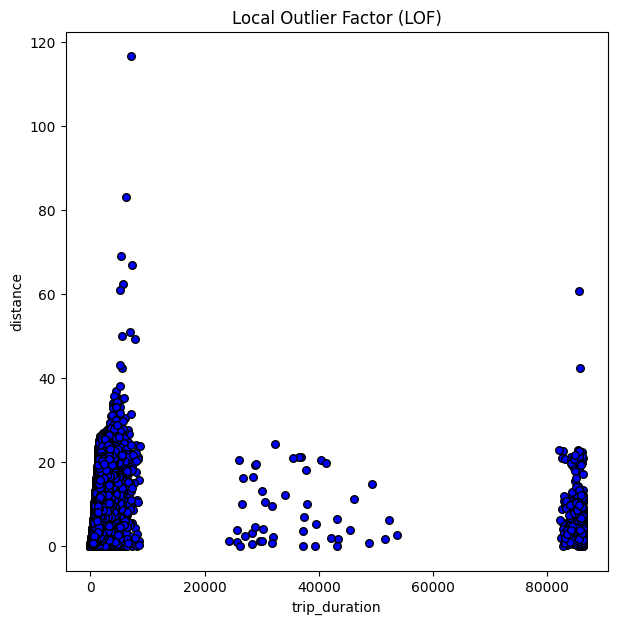

In [94]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors=50, contamination='auto')
x = trip_duration[['trip_duration','distance']].values
y_pred = LOF.fit_predict(x)

plt.figure(figsize=(10,10))


in_mask = [True if i == 1 else False for i in y_pred]
out_mask = [True if i == -1 else False for i in y_pred]

plt.title("Local Outlier Factor (LOF)")

a = plt.scatter(x[in_mask, 0], x[in_mask, 1], c = 'blue', edgecolor = 'k', s = 30)
#b = plt.scatter(x[out_mask, 0], x[out_mask, 1], c = 'red', edgecolor = 'k', s = 30)

plt.axis('tight')
plt.xlabel('trip_duration');
plt.ylabel('distance');
plt.show()
     

In [96]:
def mask_f(col):
  return (col.mean() - 3*col.std()), (col.mean()  + 3*col.std())

In [107]:
mask1 = mask_f(trip_duration.trip_duration)
mask2 = mask_f(trip_duration.distance)
td = trip_duration.trip_duration[(trip_duration.trip_duration > mask1[0]) & (trip_duration.trip_duration < mask1[1])]
ds = trip_duration.distance[(trip_duration.distance > mask2[0]) & (trip_duration.distance < mask2[1])]

In [116]:
ds.max()

16.505622070030572

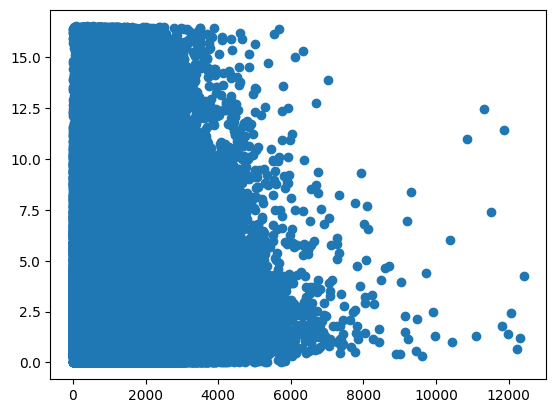

In [113]:
plt.scatter(td[:len(ds)],ds)

In [ ]:
def mask_f(col):
  return (col.mean() - 3*col.std()), (col.mean()  + 3*col.std())


mask = mask_f(trip_duration.distance)
sns.displot(trip_duration.distance[(trip_duration.distance > mask[0]) & (trip_duration.distance < mask[1])], kind="kde")
mask = mask_f(trip_duration.trip_duration)
sns.displot(trip_duration.trip_duration[(trip_duration.distance > mask[0]) & (trip_duration.trip_duration < mask[1])], kind="kde")
mask = mask_f(trip_duration.avg_speed)
sns.displot(trip_duration.avg_speed[(trip_duration.avg_speed > mask[0]) & (trip_duration.avg_speed < mask[1])], kind="kde")